In [26]:
print("bruh")
import csv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from rocketpy import Environment


import pickle

with open('flight_data.pkl', 'rb') as f:
    results = pickle.load(f)
    
#print(results)

site_lat = 35.3466
site_lon = -117.809 
site_alt = 2000/3.281 #ft


env = Environment(latitude=site_lat, longitude=site_lon, elevation=site_alt,date=(2026, 1, 18, 8), # year, month, day, hour
timezone="US/Pacific")
env.set_atmospheric_model(type="Forecast", file="GFS")



bruh



Gravity Details

Acceleration of gravity at surface level:    9.7948 m/s²
Acceleration of gravity at  78.415 km (ASL): 9.5601 m/s²


Launch Site Details

Launch Date: 2026-01-18 16:00:00 UTC | 2026-01-18 08:00:00 US/Pacific
Launch Site Latitude: 35.34660°
Launch Site Longitude: -117.80900°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 426489.24 W    3911781.04 N
Launch Site UTM zone: 11S
Launch Site Surface Elevation: 905.9 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 78.415 km
Forecast Time Period: from 2026-01-17 18:00:00 to 2026-02-02 18:00:00 utc
Forecast Hour Interval: 3 hrs
Forecast Latitude Range: From -90.0° to 90.0°
Forecast Longitude Range: From 0.0° to 359.75°

Surface Atmospheric Conditions

Surface Wind Speed: 1.72 m/s
Surface Wind Direction: 35.48°
Surface Wind Heading: 215.48°
Surface Pressure: 918.10 hPa
Surface Temperature: 286.80 K
Surface Air Density: 1.115 kg/m³
Surface Speed of Sound: 339.50 m/s


Earth Model 

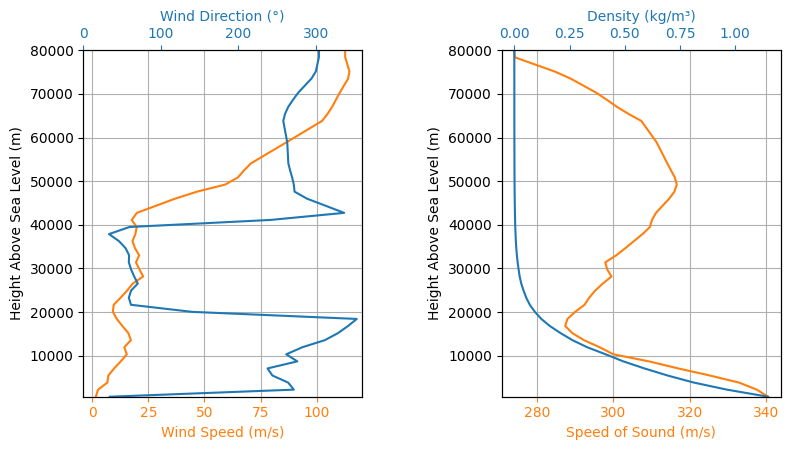

In [27]:
env.info()

In [3]:


def quaternion_to_angle_from_vertical(e0, e1, e2, e3):
    """
    Convert quaternion to angle from vertical (zenith angle)
    
    Parameters:
    e0, e1, e2, e3: Quaternion components
    
    Returns:
    angle_degrees: Angle from vertical in degrees
    """
    # Normalize quaternion (just in case)
    norm = np.sqrt(e0**2 + e1**2 + e2**2 + e3**2)
    e0, e1, e2, e3 = e0/norm, e1/norm, e2/norm, e3/norm
    
    # The vertical direction in body frame after rotation
    # Original vertical is [0, 0, 1] (pointing up)
    # Apply quaternion rotation to get current vertical direction
    
    # Quaternion rotation formula for vector [0, 0, 1]
    vx = 2 * (e0*e2 + e1*e3)
    vy = 2 * (e1*e2 - e0*e3)
    vz = e0**2 - e1**2 - e2**2 + e3**2
    
    # Angle from vertical is the angle between [0, 0, 1] and [vx, vy, vz]
    # cos(angle) = dot product with [0, 0, 1] = vz
    angle_rad = np.arccos(np.clip(vz, -1, 1))
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

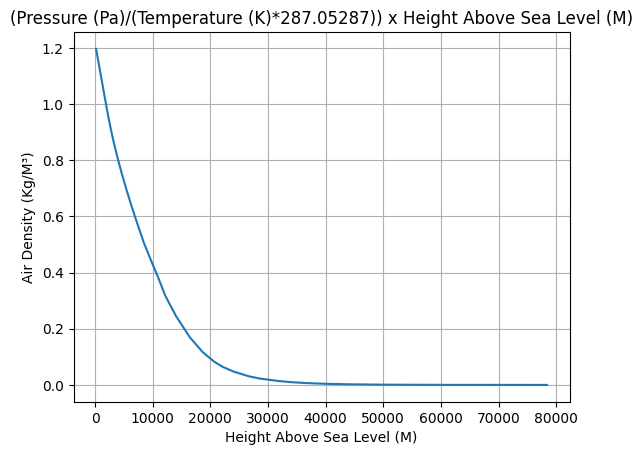

None


In [ ]:
#Process the data

# solution[time_step] = [
#     t,           # 0: Time (s)
#     x,           # 1: X position (m) - East direction
#     y,           # 2: Y position (m) - North direction  
#     z,           # 3: Z position (m) - Altitude
#     vx,          # 4: X velocity (m/s)
#     vy,          # 5: Y velocity (m/s)
#     vz,          # 6: Z velocity (m/s)
#     e0,          # 7: Quaternion component 0
#     e1,          # 8: Quaternion component 1
#     e2,          # 9: Quaternion component 2
#     e3,          # 10: Quaternion component 3
#     omega_x,     # 11: Angular velocity X (rad/s)
#     omega_y,     # 12: Angular velocity Y (rad/s)
#     omega_z      # 13: Angular velocity Z (rad/s)
# ]


x_data = []
y_data = []
x_apogee = []
y_apogee = []
z_apogee = []

ignitionangles = []
ignitiontimings = []
ignitionvelocites = []
maxvelocity = []
maxmachs = []

maxqlist = []

#print(results)
for x in results:
    if x[-1][0] > 60:
        x_data.append(x[-1][1])
        y_data.append(x[-1][2])
        ignitiontimings.append(x[0][0])
        ignitionvelocites.append(x[0][6]*3.281)
        thisflightignitionangle = quaternion_to_angle_from_vertical(x[0][7],x[0][8],x[0][9],x[0][10])
        ignitionangles.append(thisflightignitionangle)
        #print(thisflightignitionangle)

        apogee = 0
        apogee_x = 0
        apogee_y = 0
        apogee_index = 0

        max_v = 1
        maxmach = 0.1

        maxq = 1

        for y in x:

            currentvelocity = np.sqrt((y[4]*y[4])+((y[5]*y[5]))+(y[6]*y[6]))

            if currentvelocity > max_v:
                max_v = currentvelocity

            currentmach = currentvelocity/env.speed_of_sound(y[3])
            if currentmach > maxmach:
                maxmach = currentmach

            currentq = ((currentvelocity*currentvelocity)*env.density(y[3]))/2
            if currentq > maxq:
                maxq = currentq

            if y[3] > apogee:
                apogee = y[3]
                apogee_x = y[1]
                apogee_y = y[2]
                apogee_index = apogee_index + 1


            else:
                break


        x_apogee.append(x[apogee_index][1])
        y_apogee.append(x[apogee_index][2])
        z_apogee.append(apogee)
        maxvelocity.append(max_v*3.281)
        maxmachs.append(maxmach)
        maxqlist.append(maxq/6895)

        

        
        #print(str(apogee) + " at " + str(apogee_index))


#print(env.density())



In [29]:

origin_lat = site_lat  # Replace with your launch site
origin_lon = site_lon

# Convert meters to GPS coordinates
meters_per_degree_lat = 111320
meters_per_degree_lon = 111320 * np.cos(np.radians(origin_lat))

# Landing coordinates
lat_landing = [origin_lat + (y / meters_per_degree_lat) for y in y_data]
lon_landing = [origin_lon + (x / meters_per_degree_lon) for x in x_data]

# Apogee coordinates
lat_apogee = [origin_lat + (y / meters_per_degree_lat) for y in y_apogee]
lon_apogee = [origin_lon + (x / meters_per_degree_lon) for x in x_apogee]

# Calculate statistics for landing
mean_lat_landing = np.mean(lat_landing)
mean_lon_landing = np.mean(lon_landing)
mean_x_landing = np.mean(x_data)
mean_y_landing = np.mean(y_data)
std_x_landing = np.std(x_data)
std_y_landing = np.std(y_data)

# Calculate statistics for apogee
mean_lat_apogee = np.mean(lat_apogee)
mean_lon_apogee = np.mean(lon_apogee)
mean_x_apogee = np.mean(x_apogee)
mean_y_apogee = np.mean(y_apogee)
mean_z_apogee = np.mean(z_apogee)
std_x_apogee = np.std(x_apogee)
std_y_apogee = np.std(y_apogee)
std_z_apogee = np.std(z_apogee)

# Function to create circle coordinates
def create_circle(center_lon, center_lat, radius_x, radius_y, num_points=100):
    """Create circle coordinates in lon/lat"""
    angles = np.linspace(0, 2*np.pi, num_points)
    lons = center_lon + (radius_x / meters_per_degree_lon) * np.cos(angles)
    lats = center_lat + (radius_y / meters_per_degree_lat) * np.sin(angles)
    return lons, lats



# Create KML file
kml_content = f"""<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2">
<Document>
    <name>Rocket Flight Data</name>
    <description>Landing points and apogee locations with standard deviation ellipses</description>
    
    <!-- Style for launch site -->
    <Style id="launchStyle">
    <IconStyle>
        <color>ff00ff00</color>
        <scale>1.5</scale>
        <Icon>
        <href>http://maps.google.com/mapfiles/kml/shapes/star.png</href>
        </Icon>
    </IconStyle>
    </Style>
    
    <!-- Style for landing points -->
    <Style id="landingStyle">
      <IconStyle>
        <color>ff0000ff</color>
        <scale>1.0</scale>
        <Icon>
          <href>http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png</href>
        </Icon>
      </IconStyle>
      <LabelStyle>
        <scale>0.3</scale>
        <color>ffffffff</color>
      </LabelStyle>
    </Style>
    
    <!-- Style for apogee points -->
    <Style id="apogeeStyle">
    <IconStyle>
        <color>ffff00ff</color>
        <scale>1.0</scale>
        <Icon>
        <href>http://maps.google.com/mapfiles/kml/shapes/triangle.png</href>
        </Icon>
    </IconStyle>
    <LabelStyle>
        <scale>0.3</scale>
        <color>ffffffff</color>
      </LabelStyle>
    </Style>
    
    <!-- Style for mean landing -->
    <Style id="meanLandingStyle">
    <IconStyle>
        <color>ff00ffff</color>
        <scale>1.3</scale>
        <Icon>
        <href>http://maps.google.com/mapfiles/kml/shapes/target.png</href>
        </Icon>
    </IconStyle>
    </Style>
    
    <!-- Style for mean apogee -->
    <Style id="meanApogeeStyle">
    <IconStyle>
        <color>ffff00aa</color>
        <scale>1.3</scale>
        <Icon>
        <href>http://maps.google.com/mapfiles/kml/shapes/square.png</href>
        </Icon>
    </IconStyle>
    </Style>
    
    <!-- Style for landing std dev circles -->
    <Style id="landingSigma1">
    <LineStyle>
        <color>ff0000ff</color>
        <width>3</width>
    </LineStyle>
    <PolyStyle>
        <color>220000ff</color>
        <fill>1</fill>
        <outline>1</outline>
    </PolyStyle>
    </Style>
    
    <Style id="landingSigma2">
    <LineStyle>
        <color>ff0099ff</color>
        <width>3</width>
    </LineStyle>
    <PolyStyle>
        <color>110099ff</color>
        <fill>1</fill>
        <outline>1</outline>
    </PolyStyle>
    </Style>
    
    <Style id="landingSigma3">
    <LineStyle>
        <color>ff00ffff</color>
        <width>3</width>
    </LineStyle>
    <PolyStyle>
        <color>0800ffff</color>
        <fill>1</fill>
        <outline>1</outline>
    </PolyStyle>
    </Style>
    
    <!-- Style for apogee std dev circles -->
    <Style id="apogeeSigma1">
    <LineStyle>
        <color>ffff00ff</color>
        <width>3</width>
    </LineStyle>
    <PolyStyle>
        <color>22ff00ff</color>
        <fill>1</fill>
        <outline>1</outline>
    </PolyStyle>
    </Style>
    
    <Style id="apogeeSigma2">
    <LineStyle>
        <color>ffff99ff</color>
        <width>3</width>
    </LineStyle>
    <PolyStyle>
        <color>11ff99ff</color>
        <fill>1</fill>
        <outline>1</outline>
    </PolyStyle>
    </Style>
    
    <Style id="apogeeSigma3">
    <LineStyle>
        <color>ffffff00</color>
        <width>3</width>
    </LineStyle>
    <PolyStyle>
        <color>08ffff00</color>
        <fill>1</fill>
        <outline>1</outline>
    </PolyStyle>
    </Style>
    
    <!-- Launch site -->
    <Placemark>
    <name>Launch Site</name>
    <description>Origin point (0,0)</description>
    <styleUrl>#launchStyle</styleUrl>
    <Point>
        <coordinates>{origin_lon},{origin_lat},0</coordinates>
    </Point>
    </Placemark>
    
    <!-- Mean landing point -->
    <Placemark>
    <name>Mean Landing Point</name>
    <description>Average: {mean_x_landing:.1f}m East, {mean_y_landing:.1f}m North&lt;br/&gt;Std Dev: {std_x_landing:.1f}m x {std_y_landing:.1f}m</description>
    <styleUrl>#meanLandingStyle</styleUrl>
    <Point>
        <coordinates>{mean_lon_landing},{mean_lat_landing},0</coordinates>
    </Point>
    </Placemark>
    
    <!-- Mean apogee point -->
    <Placemark>
    <name>Mean Apogee Point</name>
    <description>Average: {mean_x_apogee:.1f}m East, {mean_y_apogee:.1f}m North, {mean_z_apogee:.1f}m altitude&lt;br/&gt;Std Dev: {std_x_apogee:.1f}m x {std_y_apogee:.1f}m (horizontal), {std_z_apogee:.1f}m (vertical)</description>
    <styleUrl>#meanApogeeStyle</styleUrl>
    <Point>
        <altitudeMode>absolute</altitudeMode>
        <coordinates>{mean_lon_apogee},{mean_lat_apogee},{mean_z_apogee}</coordinates>
    </Point>
    </Placemark>
"""

# Add landing standard deviation ellipses
for sigma, style, name in [(1, 'landingSigma1', 'Landing 1 Std Dev'), 
                            (2, 'landingSigma2', 'Landing 2 Std Dev'), 
                            (3, 'landingSigma3', 'Landing 3 Std Dev')]:
    lons, lats = create_circle(mean_lon_landing, mean_lat_landing, sigma * std_x_landing, sigma * std_y_landing)
    coords = ' '.join([f"{lon},{lat},0" for lon, lat in zip(lons, lats)])
    
    kml_content += f"""
    <Placemark>
    <name>{name} Ellipse</name>
    <description>{name}: {sigma * std_x_landing:.1f}m x {sigma * std_y_landing:.1f}m</description>
    <styleUrl>#{style}</styleUrl>
    <Polygon>
        <outerBoundaryIs>
        <LinearRing>
            <coordinates>
            {coords}
            </coordinates>
        </LinearRing>
        </outerBoundaryIs>
    </Polygon>
    </Placemark>
"""

# # Add apogee standard deviation ellipses
# for sigma, style, name in [(1, 'apogeeSigma1', 'Apogee 1 Std Dev'), 
#                             (2, 'apogeeSigma2', 'Apogee 2 Std Dev'), 
#                             (3, 'apogeeSigma3', 'Apogee 3 Std Dev')]:
#     lons, lats = create_circle(mean_lon_apogee, mean_lat_apogee, sigma * std_x_apogee, sigma * std_y_apogee)
#     coords = ' '.join([f"{lon},{lat},{mean_z_apogee}" for lon, lat in zip(lons, lats)])
    
#     kml_content += f"""
#     <Placemark>
#     <name>{name} Ellipse</name>
#     <description>{name}: {sigma * std_x_apogee:.1f}m x {sigma * std_y_apogee:.1f}m at ~{mean_z_apogee:.1f}m altitude</description>
#     <styleUrl>#{style}</styleUrl>
#     <Polygon>
#         <altitudeMode>absolute</altitudeMode>
#         <outerBoundaryIs>
#         <LinearRing>
#             <coordinates>
#             {coords}
#             </coordinates>
#         </LinearRing>
#         </outerBoundaryIs>
#     </Polygon>
#     </Placemark>
# """

# Add all landing points
for i, (lon, lat, x, y) in enumerate(zip(lon_landing, lat_landing, x_data, y_data), 1):
    kml_content += f"""
    <Placemark>
    <name>Landing {i}</name>
    <description>Offset: {x:.1f}m East, {y:.1f}m North</description>
    <styleUrl>#landingStyle</styleUrl>
    <Point>
        <coordinates>{lon},{lat},0</coordinates>
    </Point>
    </Placemark>
"""

# # Add all apogee points
# for i, (lon, lat, x, y, z) in enumerate(zip(lon_apogee, lat_apogee, x_apogee, y_apogee, z_apogee), 1):
#     kml_content += f"""
#     <Placemark>
#     <name>Apogee {i}</name>
#     <description>Position: {x:.1f}m East, {y:.1f}m North&lt;br/&gt;Altitude: {z:.1f}m</description>
#     <styleUrl>#apogeeStyle</styleUrl>
#     <Point>
#         <altitudeMode>absolute</altitudeMode>
#         <coordinates>{lon},{lat},{z}</coordinates>
#     </Point>
#     </Placemark>
# """

kml_content += """
</Document>
</kml>
"""

# Save to file with UTF-8 encoding
filename = "rocket_flight_data.kml"
with open(filename, 'w', encoding='utf-8') as f:
    f.write(kml_content)

print(f"KML file saved as '{filename}'")
print(f"\nLaunch site: {origin_lat:.6f}, {origin_lon:.6f}")
print(f"\nLanding Statistics:")
print(f"  Mean: {mean_lat_landing:.6f}, {mean_lon_landing:.6f} ({mean_x_landing:.1f}m E, {mean_y_landing:.1f}m N)")
print(f"  Std Dev: {std_x_landing:.1f}m (E-W) x {std_y_landing:.1f}m (N-S)")
print(f"\nApogee Statistics:")
print(f"  Mean: {mean_lat_apogee:.6f}, {mean_lon_apogee:.6f} ({mean_x_apogee:.1f}m E, {mean_y_apogee:.1f}m N)")
print(f"  Mean Altitude: {mean_z_apogee:.1f}m ± {std_z_apogee:.1f}m")
print(f"  Horizontal Std Dev: {std_x_apogee:.1f}m (E-W) x {std_y_apogee:.1f}m (N-S)")
print(f"\nTotal flights: {len(lat_landing)}")


KML file saved as 'rocket_flight_data.kml'

Launch site: 35.346600, -117.809000

Landing Statistics:
  Mean: 35.350317, -117.806738 (205.3m E, 413.8m N)
  Std Dev: 4041.6m (E-W) x 3371.3m (N-S)

Apogee Statistics:
  Mean: 35.349365, -117.807445 (141.2m E, 307.8m N)
  Mean Altitude: 18420.0m ± 1816.0m
  Horizontal Std Dev: 2997.6m (E-W) x 2497.1m (N-S)

Total flights: 94


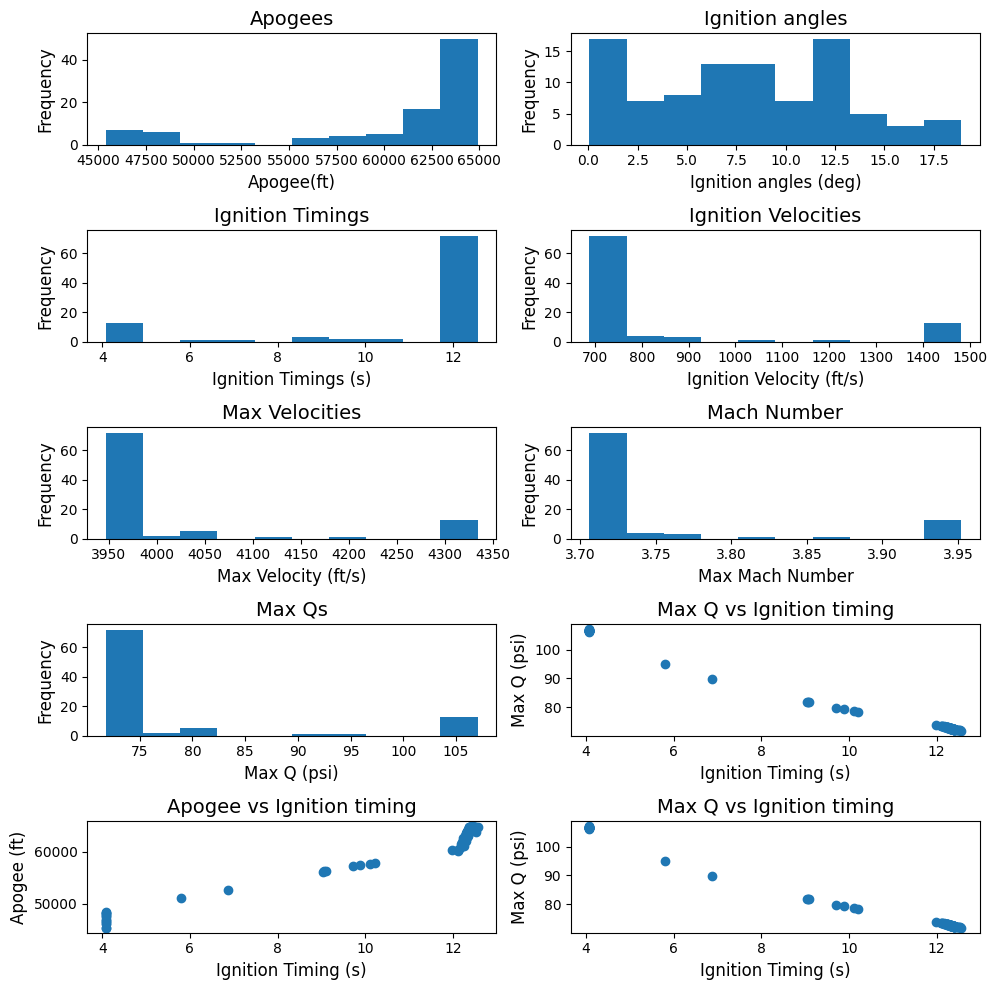

In [55]:

#MATPLOTLIB PLOTS------------------------------------------------------------------

fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5, 2, figsize=(10, 10))


z_apogee_ft = [i * 3.281 for i in z_apogee]

ax1.hist(z_apogee_ft)
ax1.set_xlabel('Apogee(ft)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Apogees', fontsize=14)


ax2.hist(ignitionangles)
ax2.set_xlabel('Ignition angles (deg)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Ignition angles', fontsize=14)

ax3.hist(ignitiontimings)
ax3.set_xlabel('Ignition Timings (s)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Ignition Timings', fontsize=14)

ax4.hist(ignitionvelocites)
ax4.set_xlabel('Ignition Velocity (ft/s)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Ignition Velocities', fontsize=14)

ax5.hist(maxvelocity)
ax5.set_xlabel('Max Velocity (ft/s)', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)
ax5.set_title('Max Velocities', fontsize=14)

ax6.hist(maxmachs)
ax6.set_xlabel('Max Mach Number', fontsize=12)
ax6.set_ylabel('Frequency', fontsize=12)
ax6.set_title('Mach Number', fontsize=14)

ax7.hist(maxqlist)
ax7.set_xlabel('Max Q (psi)', fontsize=12)
ax7.set_ylabel('Frequency', fontsize=12)
ax7.set_title('Max Qs', fontsize=14)

ax8.scatter(ignitiontimings,maxqlist)
ax8.set_xlabel('Ignition Timing (s)', fontsize=12)
ax8.set_ylabel('Max Q (psi)', fontsize=12)
ax8.set_title('Max Q vs Ignition timing', fontsize=14)

ax9.scatter(ignitiontimings,z_apogee_ft)
ax9.set_xlabel('Ignition Timing (s)', fontsize=12)
ax9.set_ylabel('Apogee (ft)', fontsize=12)
ax9.set_title('Apogee vs Ignition timing', fontsize=14)

ax10.scatter(ignitiontimings,maxqlist)
ax10.set_xlabel('Ignition Timing (s)', fontsize=12)
ax10.set_ylabel('Max Q (psi)', fontsize=12)
ax10.set_title('Max Q vs Ignition timing', fontsize=14)

plt.tight_layout()

plt.show()

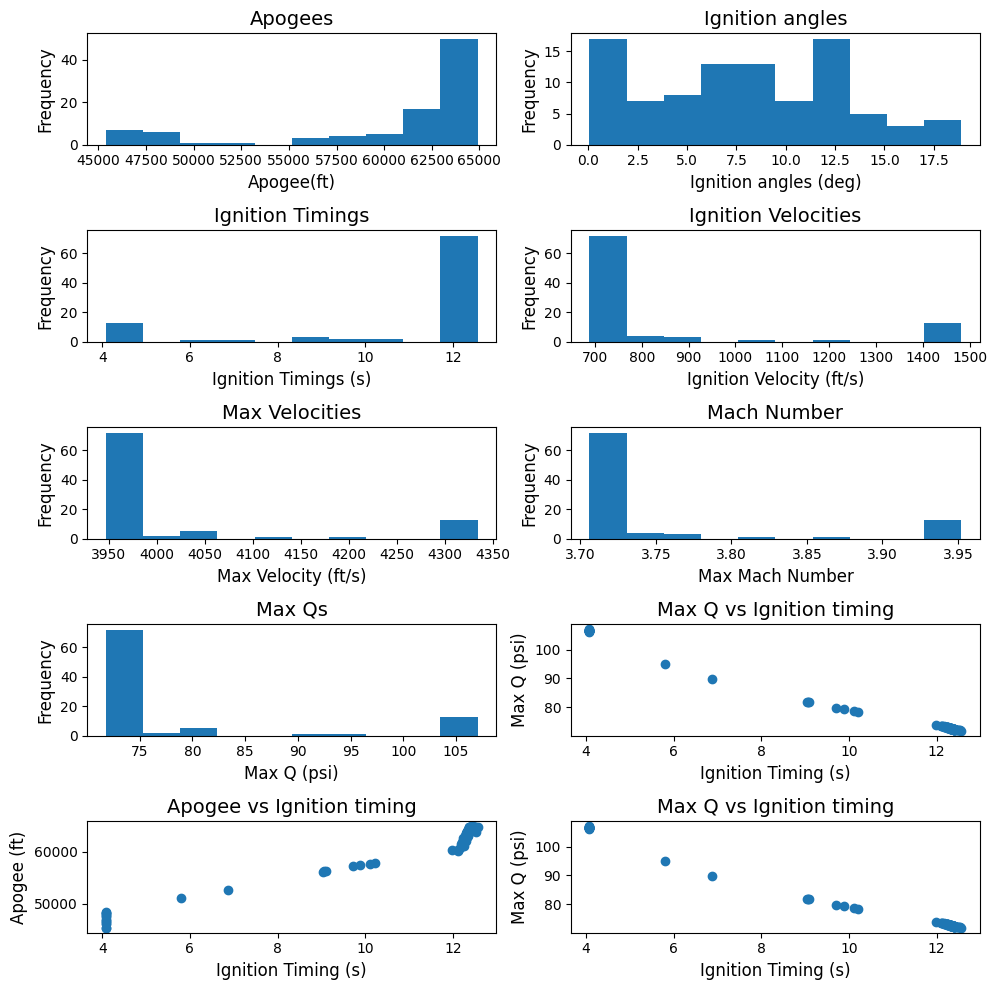

In [56]:

fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5, 2, figsize=(10, 10))

ax1.hist(z_apogee_ft)
ax1.set_xlabel('Apogee(ft)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Apogees', fontsize=14)

ax2.hist(ignitionangles)
ax2.set_xlabel('Ignition angles (deg)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Ignition angles', fontsize=14)

ax3.hist(ignitiontimings)
ax3.set_xlabel('Ignition Timings (s)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Ignition Timings', fontsize=14)

ax4.hist(ignitionvelocites)
ax4.set_xlabel('Ignition Velocity (ft/s)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Ignition Velocities', fontsize=14)

ax5.hist(maxvelocity)
ax5.set_xlabel('Max Velocity (ft/s)', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)
ax5.set_title('Max Velocities', fontsize=14)

ax6.hist(maxmachs)
ax6.set_xlabel('Max Mach Number', fontsize=12)
ax6.set_ylabel('Frequency', fontsize=12)
ax6.set_title('Mach Number', fontsize=14)

ax7.hist(maxqlist)
ax7.set_xlabel('Max Q (psi)', fontsize=12)
ax7.set_ylabel('Frequency', fontsize=12)
ax7.set_title('Max Qs', fontsize=14)

ax8.scatter(ignitiontimings,maxqlist)
ax8.set_xlabel('Ignition Timing (s)', fontsize=12)
ax8.set_ylabel('Max Q (psi)', fontsize=12)
ax8.set_title('Max Q vs Ignition timing', fontsize=14)

ax9.scatter(ignitiontimings,z_apogee_ft)
ax9.set_xlabel('Ignition Timing (s)', fontsize=12)
ax9.set_ylabel('Apogee (ft)', fontsize=12)
ax9.set_title('Apogee vs Ignition timing', fontsize=14)

ax10.scatter(ignitiontimings,maxqlist)
ax10.set_xlabel('Ignition Timing (s)', fontsize=12)
ax10.set_ylabel('Max Q (psi)', fontsize=12)
ax10.set_title('Max Q vs Ignition timing', fontsize=14)

plt.tight_layout()

plt.show()